In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sktime.forecasting.base import ForecastingHorizon


In [155]:
# Read the CSV file into a DataFrame
df = pd.read_csv('./AirtrafficA4.csv')

df['PASSENGERS CARRIED'] = df['PASSENGERS CARRIED'].str.replace(',', '').astype(float)
df.fillna(1, inplace=True)


# create column for year_month
d = {'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04', 'MAY': '05', 'JUNE': '06', 'JULY': '07', 'AUG': '08', 'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'}
df['MONTH'] = df['MONTH'].str.replace(' ', '')
df['year_month'] = df['YEAR'].astype(str) + "-" + df['MONTH'].map(d).astype(str)
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
df['year_month_period'] = df['year_month'].dt.to_period("M")

# sort values by time, reset the indices
df.sort_values(by=['year_month'], inplace=True)
df.reset_index(inplace=True)

# create a column for logs of values
df['log_pass'] = np.log(df['PASSENGERS CARRIED'])

# df.head(50)

In [156]:
# Prepare the data and forecasting horizon
y = df.set_index('year_month_period')['PASSENGERS CARRIED']
fh = ForecastingHorizon(
    pd.PeriodIndex(pd.date_range("2023-09", periods=12, freq="ME")), is_relative=False
)

df_input = pd.DataFrame({
    'ds' : df['year_month'],
    'y' : df['PASSENGERS CARRIED']
})
# df_input

In [157]:
# Treat the outliers as 'holidays'

covid = pd.DataFrame([
    {'holiday' : '1', 'ds' : '2020-03-01', 'lower_window' : 0, 'ds_upper' : '2022-09-01'}
])

for t_col in ['ds', 'ds_upper']:
    covid[t_col] = pd.to_datetime(covid[t_col])
covid['upper_window'] = (covid['ds_upper'] - covid['ds']).dt.days

In [158]:
# Using the Prophet model
""" The `yhat` column gives the predicted values """

m = Prophet(holidays=covid)
m.fit(df_input)
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)
forecast.tail(12)

22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:55 - cmdstanpy - INFO - Chain [1] done processing
d:\IITB-Sem3_courses\CS215\Assignments\Assignment4\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,1,1_lower,1_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
128,2023-08-31,7.511018e+06,7.139174e+06,7.559648e+06,7.510973e+06,7.511082e+06,0.0,0.0,0.0,-158848.984247,-158848.984247,-158848.984247,0.0,0.0,0.0,-158848.984247,-158848.984247,-158848.984247,0.0,0.0,0.0,7.352169e+06
129,2023-09-30,7.545154e+06,7.001041e+06,7.416054e+06,7.543579e+06,7.546694e+06,0.0,0.0,0.0,-334987.493347,-334987.493347,-334987.493347,0.0,0.0,0.0,-334987.493347,-334987.493347,-334987.493347,0.0,0.0,0.0,7.210167e+06
130,2023-10-31,7.580428e+06,7.416640e+06,7.813480e+06,7.576448e+06,7.583838e+06,0.0,0.0,0.0,34485.821136,34485.821136,34485.821136,0.0,0.0,0.0,34485.821136,34485.821136,34485.821136,0.0,0.0,0.0,7.614914e+06
131,2023-11-30,7.614564e+06,7.740556e+06,8.164957e+06,7.607221e+06,7.620830e+06,0.0,0.0,0.0,342907.305491,342907.305491,342907.305491,0.0,0.0,0.0,342907.305491,342907.305491,342907.305491,0.0,0.0,0.0,7.957472e+06
132,2023-12-31,7.649838e+06,7.357766e+06,7.771986e+06,7.638938e+06,7.659307e+06,0.0,0.0,0.0,-81246.421172,-81246.421172,-81246.421172,0.0,0.0,0.0,-81246.421172,-81246.421172,-81246.421172,0.0,0.0,0.0,7.568592e+06
133,2024-01-31,7.685112e+06,7.247905e+06,7.679786e+06,7.670978e+06,7.698598e+06,0.0,0.0,0.0,-209310.666364,-209310.666364,-209310.666364,0.0,0.0,0.0,-209310.666364,-209310.666364,-209310.666364,0.0,0.0,0.0,7.475801e+06
134,2024-02-29,7.718110e+06,7.485770e+06,7.897703e+06,7.698979e+06,7.735149e+06,0.0,0.0,0.0,-31795.239599,-31795.239599,-31795.239599,0.0,0.0,0.0,-31795.239599,-31795.239599,-31795.239599,0.0,0.0,0.0,7.686315e+06
135,2024-03-31,7.753384e+06,7.489701e+06,7.904657e+06,7.729461e+06,7.775207e+06,0.0,0.0,0.0,-47486.219857,-47486.219857,-47486.219857,0.0,0.0,0.0,-47486.219857,-47486.219857,-47486.219857,0.0,0.0,0.0,7.705898e+06
136,2024-04-30,7.787520e+06,7.952280e+06,8.386046e+06,7.757926e+06,7.813745e+06,0.0,0.0,0.0,390679.542712,390679.542712,390679.542712,0.0,0.0,0.0,390679.542712,390679.542712,390679.542712,0.0,0.0,0.0,8.178199e+06
137,2024-05-31,7.822794e+06,7.769494e+06,8.206350e+06,7.787307e+06,7.853853e+06,0.0,0.0,0.0,176341.159396,176341.159396,176341.159396,0.0,0.0,0.0,176341.159396,176341.159396,176341.159396,0.0,0.0,0.0,7.999135e+06


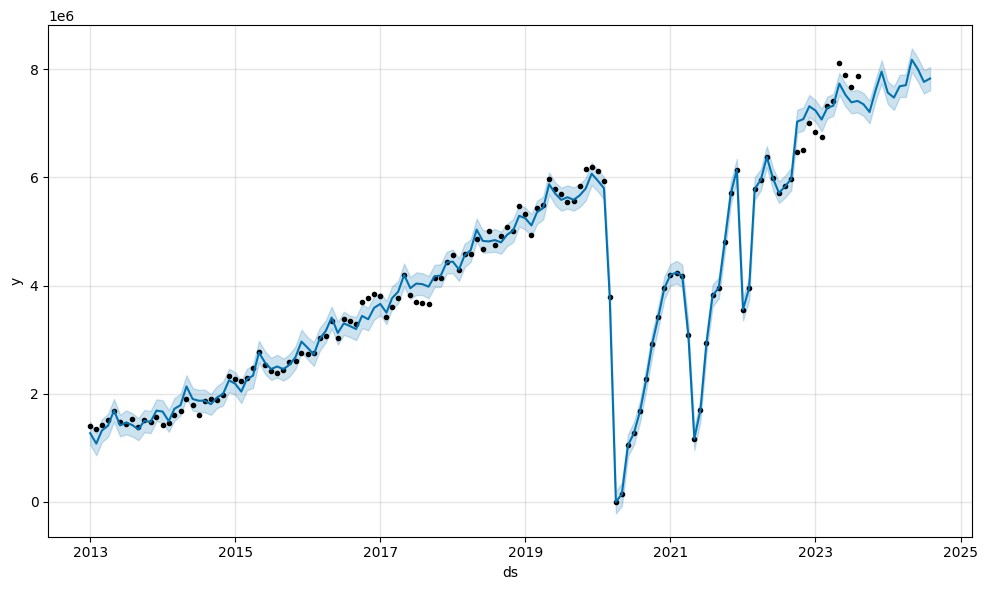

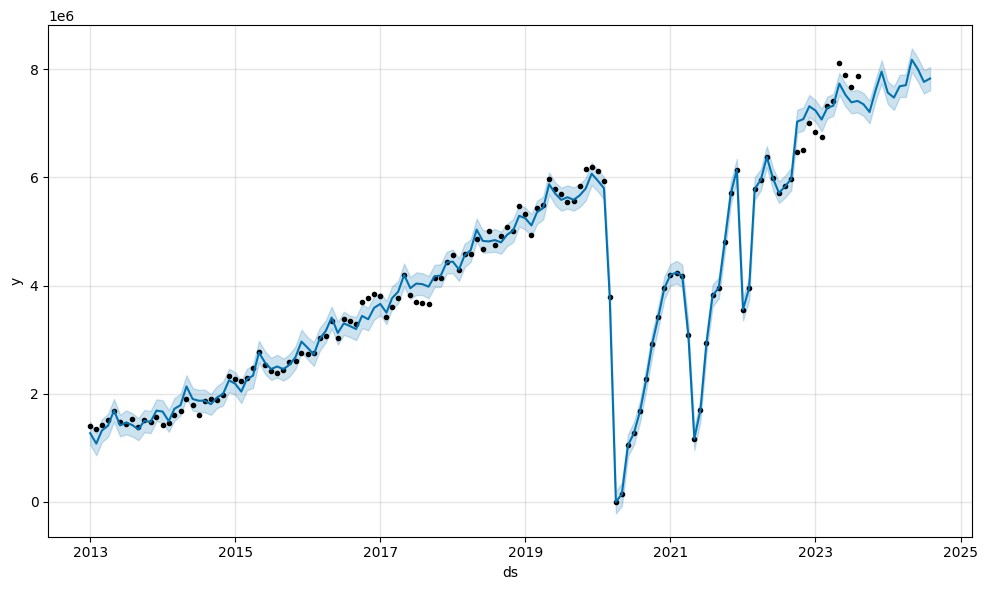

In [159]:
m.plot(forecast)